In [1]:
import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt
import numpy as np


/Users/timmonkey/Desktop/Imperial/Spring Term/Natural Language Processing/Coursework/nlp_classification/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data
train = Dataset.load_from_disk("data/train")
val = Dataset.load_from_disk("data/val")
dev = Dataset.load_from_disk("data/dev")

In [3]:
# only want the text and label columns
train_val_df = pd.concat([pd.DataFrame(train), pd.DataFrame(val)])[['text', 'pcl']]
test_df = pd.DataFrame(dev)[['text', 'pcl']]

# Apply back-translation Augmenter

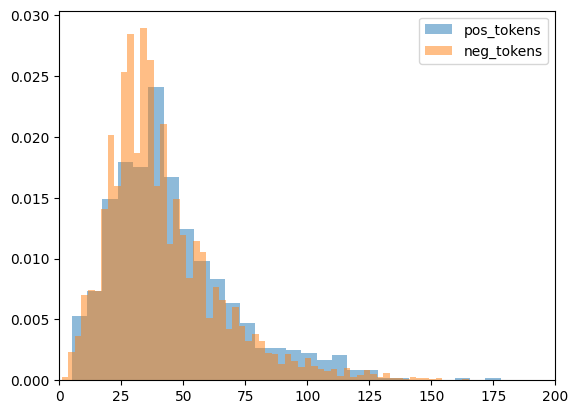

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

pos_tokens = CountVectorizer().fit_transform(train_val_df[train_val_df.pcl == 1].text.values)
pos_num_tokens = np.sum(pos_tokens.todense(), axis=1).flat


neg_tokens = CountVectorizer().fit_transform(train_val_df[train_val_df.pcl == 0].text.values)
neg_num_tokens = np.sum(neg_tokens.todense(), axis=1).flat

plt.hist(pos_num_tokens, density=True, alpha=0.5, bins='auto', label='pos_tokens')
plt.hist(neg_num_tokens, density=True, alpha=0.5, bins='auto', label='neg_tokens')
plt.xlim(0, 200)
plt.legend()
plt.show()

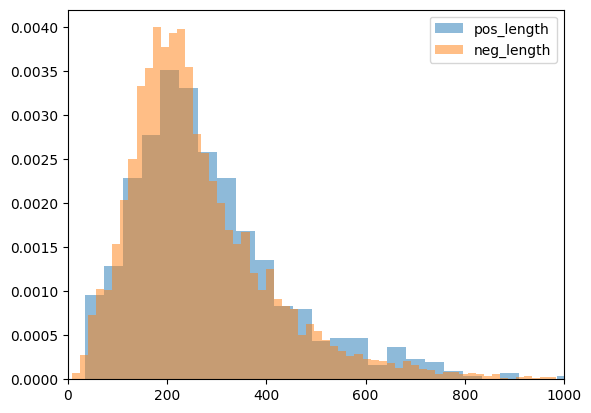

In [38]:
train_val_df[train_val_df.pcl == 1].text.apply(len)
train_val_df[train_val_df.pcl == 0].text.apply(len)
plt.hist(train_val_df[train_val_df.pcl == 1].text.apply(len).values, density=True, alpha=0.5, bins='auto', label='pos_length')
plt.hist(train_val_df[train_val_df.pcl == 0].text.apply(len).values, density=True, alpha=0.5, bins='auto', label='neg_length')
plt.xlim(0, 1000)
plt.legend()
plt.show()

In [93]:
import nlpaug.augmenter.word as naw

# can change language from any of the available models from https://huggingface.co/models?pipeline_tag=translation&sort=downloads&search=Helsinki-NLP
back_translate_aug = naw.BackTranslationAug(from_model_name='Helsinki-NLP/opus-mt-en-zh', to_model_name='Helsinki-NLP/opus-mt-zh-en')    
back_translated_text = back_translate_aug.augment(list(train_val_df[train_val_df.pcl == 1].text), num_thread=2)

data = {'text': back_translated_text, 'pcl': np.ones(len(back_translated_text))}
back_translated_df = pd.DataFrame(data)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [97]:
augmented_df = pd.concat([train_val_df, back_translated_df])
augmented_df.sample(frac=1)

,text,pcl
959,"In the report , Madius added that the threat p...",0.0
6184,"Comprising two end terrace , two storey , hous...",0.0
5491,"IPOH : As Ramadan draws to a close , Muslims s...",1.0
3134,"KOTA KINABALU , May 21 ( Bernama ) -- A total ...",0.0
15,"But in this one a pair of trends were bucked ,...",0.0
...,...,...
823,"But Emil S ? nze , a local representative of t...",0.0
3671,Social venture gives sanitary supplies for wom...,0.0
2903,Pupils from poor families were given new shoes...,0.0
3295,Tell us a little about your character Rishi in...,0.0


In [88]:
context_word_aug = naw.ContextualWordEmbsAug(action='insert')
context_word_aug.augment(list(train_val_df[train_val_df.pcl == 1][:10].text.values))
# sentence_context_text = sentence_context_aug.augment(list(train_val_df[train_val_df.pcl == 1][:10].text))

["he would andn't tolerate nonsense and he never allowed anybody to intimidate him. he was the wealthy minded and very comfortable, and someone with his wealth was very generous and kind. one in every three months, we also had banquet for all the chiefs in my community. after that of chiefs, he would organise ours for us and the children from poor working families. he used to tell us that being comfortable indoors did not mean we were special,... as only god had created everyone equally.",
 'together with her wife vicky, cornell established the chris & sara amp ; new vicky s cornell youth foundation, a charity that regularly works with vulnerable young children. the flagship charity program currently focuses on protecting these children from the ravages of homelessness, poverty, abuse online and neglect. < h > 7. cuba concert',
 'so over the whole last year, they have helped provide various types of support assistance to numerous struggling individuals and families by matching together